## Training and Eval Notebook

Training autoencoder on one month of data (360 k tensor size)
And then Evaluating the subsequent month of data

Imports

In [1]:
from eks_ml_pipeline import model_training_pipeline
from eks_ml_pipeline import node_pca_input, pod_pca_input, container_pca_input
from eks_ml_pipeline import node_autoencoder_input, pod_autoencoder_input, container_autoencoder_input
from eks_ml_pipeline import S3Utilities

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from tqdm import tqdm
import pickle

## Run the training pipeline

tensor read from: s3://dish-5g.core.pd.g.dp.eks.logs.e/node_autoencoder_ad/v0.0.3/data/tensors/training_2022_9_-1.npy
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              135168    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 20, 256)          0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          394240    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 20, 3)            771       
 ibuted)                                                         
    

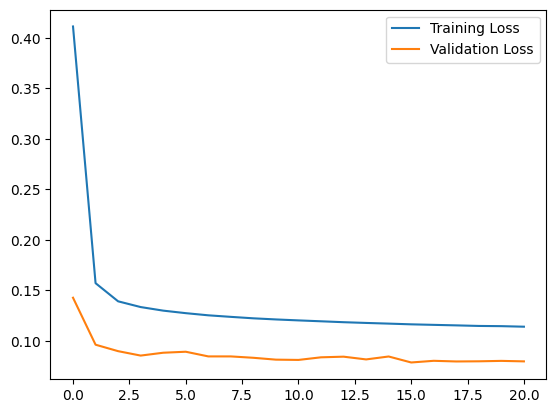

11250/11250 [==============================] - 164s 14ms/step


INFO:tensorflow:Assets written to: ../node_autoencoder/assets


INFO:tensorflow:Assets written to: ../node_autoencoder/assets



***Locally saved /root/github/node_autoencoder.zip was succesfully deleted.***

Uploaded Path: s3://dish-5g.core.pd.g.dp.eks.logs.e/node_autoencoder_ad/v0.0.3/models/zipped_models/node_autoencoder_ad_model_v0.0.3_training_2022_9_-1.zip
Uploaded Path: s3://dish-5g.core.pd.g.dp.eks.logs.e/node_autoencoder_ad/v0.0.3/models/onnx_models/node_autoencoder_ad_model_v0.0.3_training_2022_9_-1.onnx

***Locally saved model in ../node_autoencoder was succesfully deleted***



In [3]:
#Train node autoencoder model and save on s3
model_training_pipeline(*node_autoencoder_input())

 ## Now Evaluate the following month's worth of data

Import Data

In [2]:
df_oct = pd.read_parquet('/root/Data/oct_inference', engine='pyarrow')

In [3]:
df_oct.head()

,Timestamp,InstanceId,node_cpu_utilization,node_memory_utilization,node_network_total_bytes
0,2022-10-02 21:00:23.327,i-0b54b30401f3174b8,7.851202,1.841804,4.840088e+05
1,2022-10-02 21:00:16.949,i-00f549b1977d71421,0.960159,4.296771,1.634459e+06
2,2022-10-02 21:00:17.899,i-083a68dd2c550b41f,0.554449,8.512757,5.631792e+05
3,2022-10-02 21:00:24.689,i-0fce1b989f63bca3c,11.444427,2.275062,1.729096e+05
4,2022-10-02 21:00:27.062,i-02d0895ed5fe29038,0.671061,2.122322,2.746687e+04


In [4]:
## HEALTH CHECK
##print the minimum and maximum dates in this month
print(df_oct['Timestamp'].min())
print(df_oct['Timestamp'].max())

2022-09-30 23:51:26.489000
2022-10-11 13:02:19.909000


Import Model

In [9]:
def import_model_setup(encode_decode_model,
                              feature_group_name, feature_input_version, 
                              data_bucketname, train_data_filename, test_data_filename,
                              save_model_local_path, model_bucketname, model_filename,
                              upload_zip, upload_onnx, upload_npy,
                              clean_local_folder):
    
    
    
    
        ###Initialize s3 utilities class
    s3_utils = S3Utilities(bucket_name=data_bucketname, 
                           model_name=feature_group_name, 
                           version=feature_input_version)

        
    ###Load trained model: read from s3 bucket
    if upload_zip:
        s3_utils.download_zip(local_path = save_model_local_path + '.zip',
                              folder = "models",
                              type_ = "zipped_models",
                              file_name = model_filename + '.zip')
        
        s3_utils.unzip(path_to_zip = save_model_local_path + '.zip',
                       extract_location = save_model_local_path)

            

    ###Load trained model from local path
    encode_decode_model.load_model(save_model_local_path)
    
    
    return encode_decode_model
    

In [10]:
# autoencoder_trained = import_model_setup(*node_autoencoder_input())

In [5]:
with open('ZG2RS.pkl', 'rb') as f:
    autoencoder_trained = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-19 21:34:00           64
config.json                                    2023-01-19 21:34:00         3693
variables.h5                                   2023-01-19 21:34:00      2166760
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............ce

Run an inferencing job

In [6]:
## create a scalar object
scaler = StandardScaler()

In [7]:
instance_dfs =[]
for instance in tqdm(df_oct['InstanceId'].unique()):
    instance_dfs.append(df_oct[df_oct.InstanceId == instance].sort_values(by='Timestamp')\
                        .reset_index(drop=True))

100%|██████████| 421/421 [02:53<00:00,  2.43it/s]


In [10]:
features = ['node_cpu_utilization','node_memory_utilization','node_network_total_bytes']


slice_sums_for_df = []

for idf in tqdm(range(len(instance_dfs))):
    predictions_cpu = []
    predictions_memory = []
    predictions_network = []

    errors_cpu = []
    errors_memory = []
    errors_network= []
    
    slice_sums = []

    #for i in range of the dataframe, take 20 steps
    for i in range(0,len(instance_dfs[idf]),20):

        #as long as we have 20 samples to choose from
        if(i + 20 < len(instance_dfs[idf])):

            ##segment a length 20 chunk from the dataframe, drop everything except the features
            sample_topredict_on = instance_dfs[idf].iloc[i:i+20].drop(columns = ['Timestamp','InstanceId'])

            ##apply a standard scalar
            ss_sample_topredict_on = scaler.fit_transform(sample_topredict_on[features])

            ##create our xtest 3rd rank tensor
            x_test = np.array(ss_sample_topredict_on)
            x_test = x_test.reshape(1,-1,3)

            ##predict on the 3rd rank tensor and get predictions and residuals
            predict_output = autoencoder_trained.predict(x_test)

            ##grab the predictions
            preds = predict_output[0]

            ##grab the errors
            errs = predict_output[1] 


            predictions_cpu.append(np.array(preds[:,:,0]))
            predictions_memory.append(preds[:,:,1])
            predictions_network.append(preds[:,:,2])

            errors_cpu.append(errs[:,:,0])
            errors_memory.append(errs[:,:,1])
            errors_network.append(errs[:,:,2])
            
            
            sum_errs_cpu = sum(errs[:,:,0][0])/20
            sum_errs_memory = sum(errs[:,:,1][0])/20
            sum_errs_netwrk = sum(errs[:,:,2][0])/20
            start_time = instance_dfs[idf]['Timestamp'].iloc[i]
            end_time = instance_dfs[idf]['Timestamp'].iloc[i+20]
            iid = instance_dfs[idf]['InstanceId'].iloc[i]
            
            slice_sums_for_df.append((start_time,end_time,iid,sum_errs_cpu,sum_errs_memory,sum_errs_netwrk))
            
            
    
    ##concat all of the predictions for easy appending to dataframe
    predictions_cpu = np.concatenate(np.concatenate(predictions_cpu,axis=0),axis=0)
    predictions_memory = np.concatenate(np.concatenate(predictions_memory,axis=0),axis=0)
    predictions_network = np.concatenate(np.concatenate(predictions_network,axis=0),axis=0)

    errors_cpu = np.concatenate(np.concatenate(errors_cpu,axis=0),axis=0)
    errors_memory = np.concatenate(np.concatenate(errors_memory,axis=0),axis=0)
    errors_network = np.concatenate(np.concatenate(errors_network,axis=0),axis=0)
    
    
    
    ##shorten the instance df and append 6 columns
    instance_dfs[idf] = instance_dfs[idf].iloc[0:len(predictions_cpu)].assign(predictions_cpu = predictions_cpu, \
                                                                       predictions_memory = predictions_memory, \
                                                                       predictions_network = predictions_network, \
                                                                       errors_cpu = errors_cpu, \
                                                                       errors_memory = errors_memory, \
                                                                       errors_network = errors_network)
pd.concat(instance_dfs).to_csv('df_trained_list')
slice_scores_df = pd.DataFrame(slice_sums_for_df, columns =['start_time', 'end_time', 'InstanceId', 'mae_cpu','mae_memory','mae_netwrk'])
        


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
[0.01277334 0.06661412 0.02031568 0.00472331 0.16046512 0.0296171
 0.03912281 0.042393   0.0807794  0.1676552  0.14404981 0.15525245
 0.06534701 0.09638039 0.17394597 0.04904708 0.13032451 0.04751482
 0.02587707 0.16592302]
1/1 [==============================] - 0s 30ms/step
[0.07958501 0.16030802 0.08447281 0.03116608 0.13849202 0.0318636
 0.02589219 0.06619763 0.12841558 0.27716718 0.00080729 0.06718121
 0.03331059 0.07742649 0.17758061 0.01902244 0.07626112 0.12837623
 0.05714635 0.08822645]
1/1 [==============================] - 0s 46ms/step
[0.0095865  0.1283765  0.00996216 0.08663725 0.17044983 0.02772816
 0.01881979 0.01577095 0.14312727 0.15017904 0.06382874 0.08864828
 0.03621755 0.01133634 0.21766811 0.08628689 0.10256718 0.06949603
 0.05613105 0.17240495]
1/1 [==============================] - 0s 22ms/step
[0.01778749 0.10142637 0.05815974 0.12458572 0.19592331 0.03489212
 0.02013983 0.01210094 0.14329572 0.11680406 0.14653

KeyboardInterrupt: 

In [ ]:
# print("hello")

In [ ]:
# with open('tiger.pkl', 'wb') as f:
#         pickle.dump(instance_dfs, f)

In [8]:
# with open('slice_scores_df.pkl', 'wb') as f:
#         pickle.dump(slice_scores_df, f)